# Figure 2: Observed and simulated changes in sea ice

Figure 2 of ice shelf melt perturbation study:
    - observed sea ice concentration trend (1992-2011)
    - modelled sea ice concentration trend (1992-2011), control run
    - change in sea ice concentration (perturbation-control)
    - change in sea ice volume (perturbation-control)

Observations are taken from the National Snow and Ice Data Centre (https://nsidc.org/). The monthly trend is calculcated in `calc_sic_NSIDC_trend.py`.

The change in sea ice concentration in the observations and the control run is calculated as the linear trend multiplied by the number of years. The change in sea ice concentration/volume between the perturbation and the control simulation is simply their difference.

This jupyter script is based on `plot_seaice_NSIDC_MetROMS.py`.

In [1]:
# Load modules
import sys
sys.path.insert(0, '/g/data/gh9/wgh581/Python_code/plot_code/metroms_code')
from fxn_cartesian_grid_2d import *
from numpy import *
from matplotlib.pyplot import *
import matplotlib.gridspec as gridspec
from netCDF4 import Dataset
import cmocean.cm as cmo
import copy
import xarray as xr
import scipy.signal
import scipy.stats

### Import data

In [2]:
# Names for plotting
season = ['Summer', 'Autumn', 'Winter', 'Spring']
label  = ['CNTR', 'PERT']
panel_name = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)', 'g)', 'h)', \
        'i)', 'j)', 'k)', 'l)', 'm)', 'n)', 'o)', 'p)']

aice_extmin = 0.15

#### 1) Model perturbation

In [4]:
# Path
path = '/g/data/gh9/wgh581/ROMS_Output/metroms_files/'

# CICE grid (random cice history file)
cice_grid = path + 'RAW/metroms_CONTROL/cice/history/iceh.2007-01-01.nc'
# MetROMS grid (random ocean history file)
roms_grid = path + 'RAW/metroms_CONTROL/ocean_his_0042.nc'

In [5]:
aice_hi_cntr   = xr.open_dataset(path + 'POST_PROCESS/aice_hi_CONTROL_2002_2011_full_circumpolar.nc').sel(time=slice('2008-12-01','2011-11-30')).groupby('time.season').mean('time').sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
aice_hi_pert_2 = xr.open_dataset(path + 'POST_PROCESS/aice_hi_2SSFLUX_2002_2011_full_circumpolar.nc').sel(time=slice('2008-12-01','2011-11-30')).groupby('time.season').mean('time').sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
aice_hi_pert_4 = xr.open_dataset(path + 'POST_PROCESS/aice_hi_4SSFLUX_2002_2011_full_circumpolar.nc').sel(time=slice('2008-12-01','2011-11-30')).groupby('time.season').mean('time').sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))


In [6]:
# Extract aice, hi
aice_cntr   = aice_hi_cntr.aice[:,:-15,:-1]
aice_pert_2 = aice_hi_pert_2.aice[:,:-15,:-1]
aice_pert_4 = aice_hi_pert_4.aice[:,:-15,:-1]

hi_cntr   = aice_hi_cntr.hi[:,:-15,:-1]
hi_pert_2 = aice_hi_pert_2.hi[:,:-15,:-1]
hi_pert_4 = aice_hi_pert_4.hi[:,:-15,:-1]

In [7]:
# Calculate effective sea cice volume (units: m) as sea ice concentration x sea ice thickness
siv_cntr   = aice_cntr * hi_cntr
siv_pert_2 = aice_pert_2 * hi_pert_2
siv_pert_4 = aice_pert_4 * hi_pert_4

In [8]:
# Mean sea ice volume
print('mean siv, control: ', mean(siv_cntr).values)
print('mean siv, pert_2: ', mean(siv_pert_2).values)
print('mean siv, pert_4: ', mean(siv_pert_4).values)

print('')
# Max sea ice volume
print('sum siv, control: ', sum(siv_cntr).values)
print('sum siv, pert_2: ', sum(siv_pert_2).values)
print('sum siv, pert_4: ', sum(siv_pert_4).values)


mean siv, control:  0.1427703
mean siv, pert_2:  0.1467011
mean siv, pert_4:  0.14624372

sum siv, control:  220413.94
sum siv, pert_2:  226482.44
sum siv, pert_4:  225776.31


In [9]:
# Read the CICE grid
id   = Dataset(cice_grid, 'r')
lon  = id.variables['TLON'][:-15,:-1]
lat  = id.variables['TLAT'][:-15,:-1]
lon_cice = id.variables['TLON'][:,:]
lat_cice = id.variables['TLAT'][:,:]
id.close()

In [10]:
# Degrees to radians conversion
deg2rad = pi/180.0

# Convert to spherical coordinates for plotting
x = -(lat+90)*cos(lon*deg2rad+pi/2)
y = (lat+90)*sin(lon*deg2rad+pi/2)
x_cice = -(lat_cice+90)*np.cos(lon_cice*deg2rad+np.pi/2)
y_cice = (lat_cice+90)*np.sin(lon_cice*deg2rad+np.pi/2)

In [11]:
# Calculate cice grid cell area
dx, dy = cartesian_grid_2d(lon, lat)
dA = dx * dy

In [12]:
# Sea ice extent
ext_cntr   = aice_cntr * dA
ext_pert_2 = aice_pert_2 * dA
ext_pert_4 = aice_pert_4 * dA

In [13]:
print('Sea ice extent, JJA')
print('control:', ext_cntr[2,...].sum().values)
print('pert_2:', ext_pert_2[2,...].sum().values)
print('pert_4:', ext_pert_4[2,...].sum().values)

Sea ice extent, JJA
control: 12323013000000.0
pert_2: 12376716000000.0
pert_4: 12616385000000.0


In [14]:
# Increase in sea ice extent (JJA)
print('pert_2:', ((ext_pert_2[2,...].sum() / ext_cntr[2,...].sum()).values-1)*100, '%')
print('pert_4:', ((ext_pert_4[2,...].sum() / ext_cntr[2,...].sum()).values-1)*100, '%')

pert_2: 0.435793399810791 %
pert_4: 2.380681037902832 %


In [15]:
# Yearly sea ice extent
print('Sea ice extent, anuual')
print('control:', ext_cntr.mean('season').sum().values)
print('pert_2:', ext_pert_2.mean('season').sum().values)
print('pert_4:', ext_pert_4.mean('season').sum().values)
# Increases in percent
print('Increase in % (annual)')
print('pert_2:', ((ext_pert_2.mean('season').sum() / ext_cntr.mean('season').sum()).values-1)*100, '%')
print('pert_4:', ((ext_pert_4.mean('season').sum() / ext_cntr.mean('season').sum()).values-1)*100, '%')

Sea ice extent, anuual
control: 8722328300000.0
pert_2: 8784952400000.0
pert_4: 8944879000000.0
Increase in % (annual)
pert_2: 0.7179737091064453 %
pert_4: 2.5514960289001465 %


In [15]:
# Full sea ice volume (not just the effective volume which is shown in the figures)

In [16]:
# Sea ice volume
vol_cntr   = aice_cntr * dA * hi_cntr
vol_pert_2 = aice_pert_2 * dA * hi_pert_2
vol_pert_4 = aice_pert_4 * dA * hi_pert_4

In [17]:
# Changes in percent
print('pert_2:', (mean(vol_pert_2).values / mean(vol_cntr).values-1)*100, '%')
print('pert_4:', (mean(vol_pert_4).values / mean(vol_cntr).values-1)*100, '%')

pert_2: 3.033936023712158 %
pert_4: 4.035651683807373 %


ROMS grid

In [18]:
# Load Metroms grid, bathymetry, and zice
id = Dataset(roms_grid, 'r')
lat_roms = id.variables['lat_rho'][:-15,:-1]
lon_roms = id.variables['lon_rho'][:-15,:-1]
h    = id.variables['h'][:-15,:-1]
zice = id.variables['zice'][:-15,:-1]
mask = id.variables['mask_rho'][:-15,:-1]
id.close()

# Spherical coordinates
x_roms = -(lat_roms+90)*cos(lon_roms*deg2rad+pi/2)
y_roms = (lat_roms+90)*sin(lon_roms*deg2rad+pi/2)

# Masking
h = ma.masked_where(mask==0, h)
zice = ma.masked_where(mask==0, zice)
zice = ma.masked_where(zice==0, zice)
lat_r = ma.masked_where(mask==1, lat_roms)

# Center of missing circle (metroms)
lat_c   = -83
lon_c   = 50
# Radius of missing circle (play around with this until it works)
radius  = 10.1
# Find center in spherical coordinates
x_c_metroms = -(lat_c+90)*np.cos(lon_c*deg2rad+np.pi/2)
y_c_metroms = (lat_c+90)*np.sin(lon_c*deg2rad+np.pi/2)
# Build a regular x-y grid and select the missing circle
lat_max = -63+90
x_reg, y_reg = np.meshgrid(np.linspace(-lat_max, lat_max, num=1000), np.linspace(-lat_max, lat_max, num=1000))
land_circle = np.zeros(np.shape(x_reg))
land_circle_metroms = np.ma.masked_where(np.sqrt((x_reg-x_c_metroms)**2 + (y_reg-y_c_metroms)**2) > radius, land_circle)

#### 2) Model control trend (full 20 years of model simulation)

In [19]:
# Import monthly aice model data
data_1992_2002 = xr.open_dataset(path + 'POST_PROCESS/aice_1992_2002_CONTROL_monthly.nc').aice
data_2002_2012 = xr.open_dataset(path + 'POST_PROCESS/aice_2002_2012_CONTROL_monthly.nc').aice[:-11,:,:]

# Concatenate along time dimension (time is reversed)
aice_control = xr.concat([data_2002_2012, data_1992_2002], dim="time")

# Monthly climatology
months = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
trend  = np.zeros((np.size(months), np.size(aice_control,1), np.size(aice_control,2)))
aice_monthly = np.zeros((np.size(months), np.size(aice_control,1), np.size(aice_control,2)))

# Deal with nan (set to dummy value)
aice_control = aice_control.fillna(-999)

In [20]:
# Calculate trend
for nn in range(np.size(months)):

    #print('Working on: ', months[::-1][nn])
    tmp = aice_control[nn::12].values
    aice_monthly[11-nn,:,:] = tmp.mean(axis=0)
    tmp_d = scipy.signal.detrend(tmp, axis=0)
    detrn = tmp - tmp_d

    # Get the slope (backwards as the time vector goes from present to past)
    # January is last in monthly time series
    trend[11-nn,:,:] = (detrn[0,:,:] - detrn[-1,:,:]) / np.size(detrn, axis=0)

# Seasonal trend
trend_seasonal = np.zeros((len(season), np.size(aice_control,1), np.size(aice_control,2)))
trend_seasonal[0,:,:] = (trend[11,:,:] + trend[0,:,:] + trend[1,:,:]) / 3
trend_seasonal[1,:,:] = np.mean(trend[2:5,:,:], axis=0)
trend_seasonal[2,:,:] = np.mean(trend[5:8,:,:], axis=0)
trend_seasonal[3,:,:] = np.mean(trend[8:11,:,:], axis=0)

# Seasonal concentration (for masking below, to indicate sea ice edge)
aice_seasonal = zeros((len(season), size(aice_control,1), size(aice_control,2)))
aice_seasonal[0,:,:] = aice_monthly[[11, 0, 1],:,:].mean(axis=0)
aice_seasonal[1,:,:] = aice_monthly[[2, 3, 4],:,:].mean(axis=0)
aice_seasonal[2,:,:] = aice_monthly[[5, 6, 7],:,:].mean(axis=0)
aice_seasonal[3,:,:] = aice_monthly[[8, 9, 10],:,:].mean(axis=0)

# Masking
for tt in range(4):
    tmp = trend_seasonal[tt,:-15,:-1]
    # tmp[aice_seasonal[tt,:,:] < aice_extmin] = np.nan
    tmp[aice_cntr[tt,:,:] < aice_extmin] = np.nan
    trend_seasonal[tt,:-15,:-1] = tmp

# Convert to dataarray
trend_seasonal = xr.DataArray(trend_seasonal, dims=('time', 'nj', 'ni'), \
    coords={'time':season, 'TLAT':aice_control.TLAT, 'TLON':aice_control.TLON}, name='aice')

#### 3) Observations (NSIDC)

In [21]:
# Path
nsidc_path = '/g/data/gh9/wgh581/NSIDC_monthly/'

# Load grid information from a (random) original file
id = Dataset(nsidc_path + 'seaice_conc_monthly_sh_f08_199101_v03r01.nc', 'r')
lon_sic = id.variables['longitude'][:]
lat_sic = id.variables['latitude'][:]
id.close()

In [22]:
# Get circumpolar x and y coordinates for plotting
x_sic = -(lat_sic+90)*cos(lon_sic*deg2rad+pi/2)
y_sic = (lat_sic+90)*sin(lon_sic*deg2rad+pi/2)

In [23]:
# Load trend
#id = Dataset(nsidc_path + 'sic_trend_1979_2015.nc')
id = Dataset(nsidc_path + 'sic_trend_1992_2011.nc')
sic = id.variables['sic'][:]
id.close
# Calculate seasonal average
seas = zeros((4, 332, 316))
seas[0,:,:] = nanmean(sic[[0, 1, 11],:,:], axis=0)
seas[1,:,:] = nanmean(sic[[2, 3, 4],:,:], axis=0)
seas[2,:,:] = nanmean(sic[[5, 6, 7],:,:], axis=0)
seas[3,:,:] = nanmean(sic[[8, 9, 10],:,:], axis=0)

# Get delta SIC = trend * ntime
ntime_NSIDC = 2011-1992+1 #2015-1979+1
delta_SIC_NSIDC = seas * ntime_NSIDC

# sic climatology to indicate ice shelf edge on plot
#id = Dataset(nsidc_path + 'sic_climatology_1979_2015.nc')
id = Dataset(nsidc_path + 'sic_climatology_1992_2011.nc')
sic_monthly = id.variables['sic'][:]
id.close()
sic_seasonal = zeros((len(season), size(sic_monthly,1), size(sic_monthly,2)))
sic_seasonal[0,:,:] = sic_monthly[[11, 0, 1],:,:].mean(axis=0)
sic_seasonal[1,:,:] = sic_monthly[[2, 3, 4],:,:].mean(axis=0)
sic_seasonal[2,:,:] = sic_monthly[[5, 6, 7],:,:].mean(axis=0)
sic_seasonal[3,:,:] = sic_monthly[[8, 9, 10],:,:].mean(axis=0)

Masking

In [24]:
# Observations
for tt in range(4):
    tmp = delta_SIC_NSIDC[tt,:,:]
    tmp[sic_seasonal[tt,:,:] < aice_extmin] = np.nan
    delta_SIC_NSIDC[tt,:,:] = tmp

# Sea ice concentration
diff_aice_pert_2 = aice_pert_2 - aice_cntr
diff_aice_pert_2 = diff_aice_pert_2.where(aice_cntr > aice_extmin, np.nan)
diff_aice_pert_4 = aice_pert_4 - aice_cntr
diff_aice_pert_4 = diff_aice_pert_4.where(aice_cntr > aice_extmin, np.nan)
# Sea ice volume
diff_siv_pert_2 = siv_pert_2 - siv_cntr
diff_siv_pert_2 = diff_siv_pert_2.where(aice_cntr > aice_extmin, np.nan)
diff_siv_pert_4 = siv_pert_4 - siv_cntr
diff_siv_pert_4 = diff_siv_pert_4.where(aice_cntr > aice_extmin, np.nan)

## Plotting

In [25]:
# Fontsize
ft_size = 14

# Colormap
from palettable.scientific.diverging import Vik_19_r

# Resolution when saving figure
my_dpi = 150

fig_path = fig_path = '/g/data/gh9/wgh581/Python_code/MetROMS_BasalMelt_Perturbation/figures/'

/jobfs/99379321.gadi-pbs/ipykernel_988880/364557672.py:18: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  sc = pcolormesh(x_sic, y_sic, delta_SIC_NSIDC[ii,:,:], cmap=Vik_19_r.mpl_colormap, \
/jobfs/99379321.gadi-pbs/ipykernel_988880/364557672.py:36: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  sc = pcolormesh(x_cice, y_cice, trend_seasonal[ii,:,:]*20, cmap=Vik_19_r.mpl_colormap, vmin=-0.5, vmax=0.5)
/jobfs/99379321.gadi-pbs/ipykernel_988880/364557672.py:61: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decr

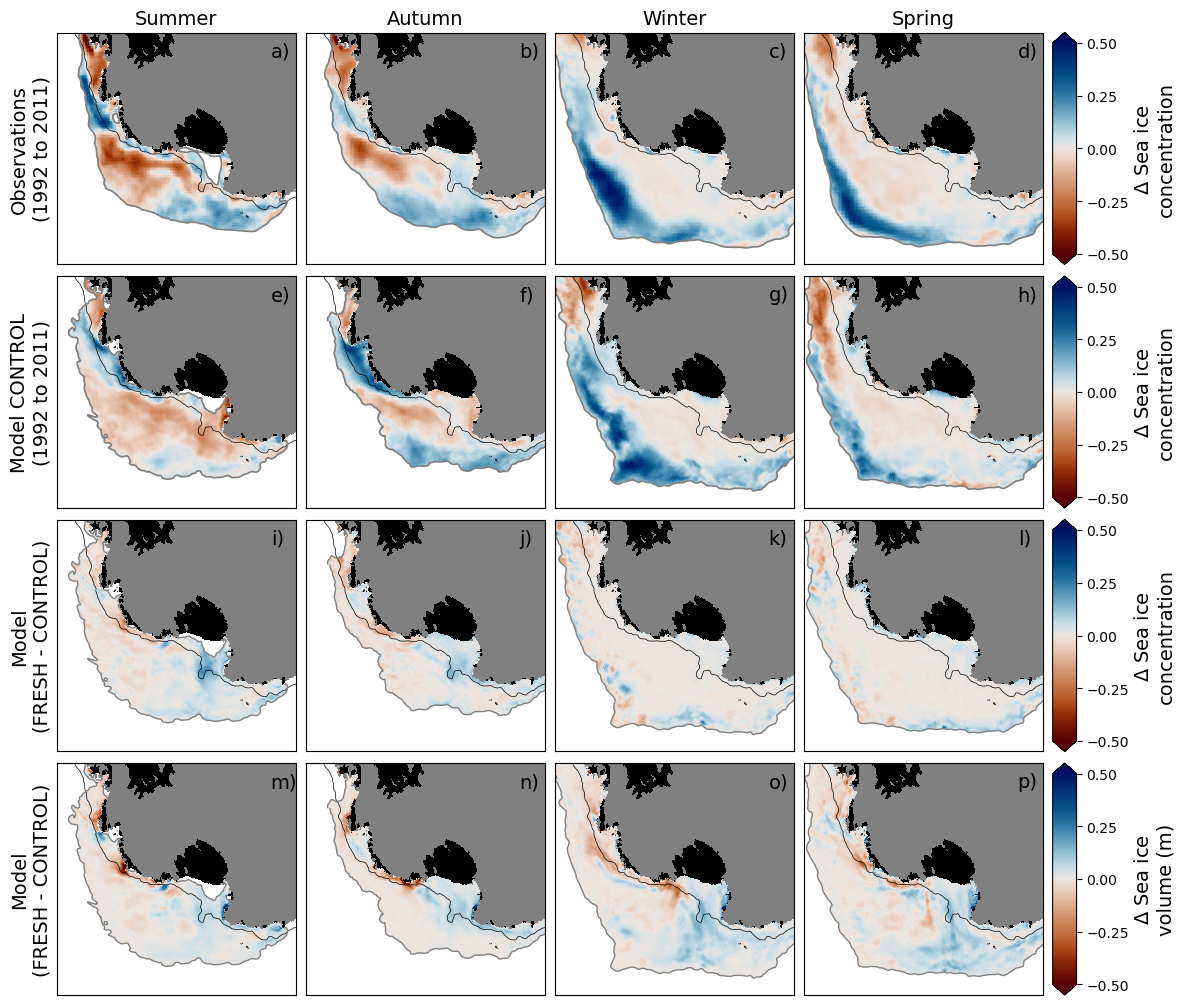

In [26]:
fig = figure(figsize=(12,11)) #(12,9)
gs  = gridspec.GridSpec(4, 1, height_ratios=[1,1,1,1], hspace=0.05)
gs0 = gridspec.GridSpecFromSubplotSpec(1, 5, width_ratios=[1,1,1,1,0.1], \
        subplot_spec=gs[0], wspace=0.05)
gs1 = gridspec.GridSpecFromSubplotSpec(1, 5, width_ratios=[1,1,1,1,0.1], \
        subplot_spec=gs[1], wspace=0.05)
gs2 = gridspec.GridSpecFromSubplotSpec(1, 5, width_ratios=[1,1,1,1,0.1], \
        subplot_spec=gs[2], wspace=0.05)
gs3 = gridspec.GridSpecFromSubplotSpec(1, 5, width_ratios=[1,1,1,1,0.1], \
        subplot_spec=gs[3], wspace=0.05)

for ii in range(len(season)):

    # Observations, delta SIC
    ax = fig.add_subplot(gs0[0,ii])#, aspect='equal')
    ax.text(0.895, 0.895, panel_name[ii], fontsize=ft_size, transform=ax.transAxes)
    title(season[ii], fontsize=ft_size)
    sc = pcolormesh(x_sic, y_sic, delta_SIC_NSIDC[ii,:,:], cmap=Vik_19_r.mpl_colormap, \
            vmin=-0.5, vmax=0.5, shading='nearest')
    contourf(x_reg, y_reg, land_circle_metroms, colors='0.5')
    contourf(x_roms, y_roms, lat_r, colors='0.5')
    contourf(x_roms, y_roms, zice*1, colors='k')
    if ii == 0:
        ylabel('Observations\n(1992 to 2011)', fontsize=ft_size)#, loc='left') #(1979 to 2015)'
    contour(x_roms, y_roms, h, levels=[1000], colors='k', linewidths=0.5)
    contour(x_sic, y_sic, sic_seasonal[ii,:,:], levels=[aice_extmin], linewidths=1.25, colors='0.5')
    setp(ax.get_xticklabels(), visible=False)
    setp(ax.get_yticklabels(), visible=False)
    ax.tick_params(axis='both', which='both', length=0)
    xlim(-25, 15)
    ylim(-30, 7)

    # Model, CNTR delta SIC
    ax = fig.add_subplot(gs1[0,ii])
    ax.text(0.895, 0.895, panel_name[ii+4], fontsize=ft_size, transform=ax.transAxes)
    sc = pcolormesh(x_cice, y_cice, trend_seasonal[ii,:,:]*20, cmap=Vik_19_r.mpl_colormap, vmin=-0.5, vmax=0.5)
    #sc = pcolormesh(x_cice, y_cice, aice_seasonal[ii,:,:], cmap=Vik_19_r.mpl_colormap, vmin=-0.5, vmax=0.5)
    contourf(x_reg, y_reg, land_circle_metroms, colors='0.5')
    contourf(x_roms, y_roms, lat_r, colors='0.5')
    contourf(x_roms, y_roms, zice*1, colors='k')
    if ii == 0:
        ylabel('Model CONTROL\n(1992 to 2011)', fontsize=ft_size)#, loc='left') #(1979 to 2015)'
    contour(x_roms, y_roms, h, levels=[1000], colors='k', linewidths=0.5)
    # contour(x_cice, y_cice, aice_seasonal[ii,:,:], levels=[aice_extmin], linewidths=1.25, colors='0.5')
    contour(x, y, aice_cntr[ii,:,:], levels=[aice_extmin], linewidths=1.25, colors='0.5')
    setp(ax.get_xticklabels(), visible=False)
    setp(ax.get_yticklabels(), visible=False)
    ax.tick_params(axis='both', which='both', length=0)
    xlim(-25, 15)
    ylim(-30, 7)
        
        
    # Model, delta SIC
    ax = fig.add_subplot(gs2[0,ii])#, aspect='equal')
    ax.text(0.895, 0.895, panel_name[ii+8], fontsize=ft_size, transform=ax.transAxes)
    contourf(x_reg, y_reg, land_circle_metroms, colors='0.5')
    contourf(x_roms, y_roms, lat_r*0, colors='0.5')
    contourf(x_roms, y_roms, zice*1, colors='k')
    contour(x_roms, y_roms, h, levels=[1000], colors='k', linewidths=0.5)
    contour(x, y, aice_cntr[ii,:,:], levels=[aice_extmin], colors='0.5', linewidths=1)
    sc = pcolormesh(x, y, diff_aice_pert_2[ii,:,:], cmap=Vik_19_r.mpl_colormap, vmin=-0.5, vmax=0.5, shading='nearest')

    if ii == 0:
        ylabel('Model\n(FRESH - CONTROL)', fontsize=ft_size)#, loc='left')
    setp(ax.get_xticklabels(), visible=False)
    setp(ax.get_yticklabels(), visible=False)
    ax.tick_params(axis='both', which='both', length=0)
    xlim(-25, 15)
    ylim(-30, 7)

    # Model, delta SIV, effective
    ax = fig.add_subplot(gs3[0,ii])#, aspect='equal')
    ax.text(0.895, 0.895, panel_name[ii+12], fontsize=ft_size, transform=ax.transAxes)
    contourf(x_reg, y_reg, land_circle_metroms, colors='0.5')
    contourf(x_roms, y_roms, lat_r*0, colors='0.5')
    contourf(x_roms, y_roms, zice*1, colors='k')
    v_val = 0.5 # 1.25
    SC = pcolormesh(x, y, diff_siv_pert_2[ii,:,:], cmap=Vik_19_r.mpl_colormap, vmin=-v_val, vmax=v_val, shading='nearest')
    contour(x_roms, y_roms, h, levels=[1000], colors='k', linewidths=0.5)
    contour(x, y, aice_cntr[ii,:,:], levels=[aice_extmin], colors='0.5', linewidths=1)
    if ii == 0:
        ylabel('Model\n(FRESH - CONTROL)', fontsize=ft_size)#, loc='left')
    setp(ax.get_xticklabels(), visible=False)
    setp(ax.get_yticklabels(), visible=False)
    ax.tick_params(axis='both', which='both', length=0)
    xlim(-25, 15)
    ylim(-30, 7)


# Add colorbars
cbar_ax1 = fig.add_subplot(gs0[:,-1])
cbar_ax2 = fig.add_subplot(gs1[:,-1])
cbar_ax3 = fig.add_subplot(gs2[:,-1])
cbar_ax4 = fig.add_subplot(gs3[:,-1])
cbar = colorbar(sc, cax=cbar_ax1, ticks=np.arange(-0.5, 0.55, 0.25), extend='both')
cbar.set_label('$\Delta$ Sea ice\nconcentration', fontsize=ft_size)
cbar = colorbar(sc, cax=cbar_ax2, ticks=np.arange(-0.5, 0.55, 0.25), extend='both')
cbar.set_label('$\Delta$ Sea ice\nconcentration', fontsize=ft_size)
cbar = colorbar(sc, cax=cbar_ax3, ticks=np.arange(-0.5, 0.55, 0.25), extend='both')
# 1.1 Volume
#cbar.set_label('$\Delta$ Sea ice volume (km$^{3}$)', fontsize=12)
# 1.2 Effective volume
cbar.set_label('$\Delta$ Sea ice\nconcentration', fontsize=ft_size)
cbar = colorbar(SC, cax=cbar_ax4, ticks=np.arange(-0.5, 0.55, 0.25), extend='both')
cbar.set_label('$\Delta$ Sea ice\nvolume (m)', fontsize=ft_size)

subplots_adjust(right=0.9, left=0.05, bottom=0.075, top=0.95)

# Finished
plot_flag = 1
if plot_flag == 1:
    savefig(fig_path + 'Figure2_2SSFLUX.png', dpi=my_dpi)


/jobfs/99379321.gadi-pbs/ipykernel_988880/3936161414.py:18: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  sc = pcolormesh(x_sic, y_sic, delta_SIC_NSIDC[ii,:,:], cmap=Vik_19_r.mpl_colormap, \
/jobfs/99379321.gadi-pbs/ipykernel_988880/3936161414.py:36: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  sc = pcolormesh(x_cice, y_cice, trend_seasonal[ii,:,:]*20, cmap=Vik_19_r.mpl_colormap, vmin=-0.5, vmax=0.5)
/jobfs/99379321.gadi-pbs/ipykernel_988880/3936161414.py:60: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or d

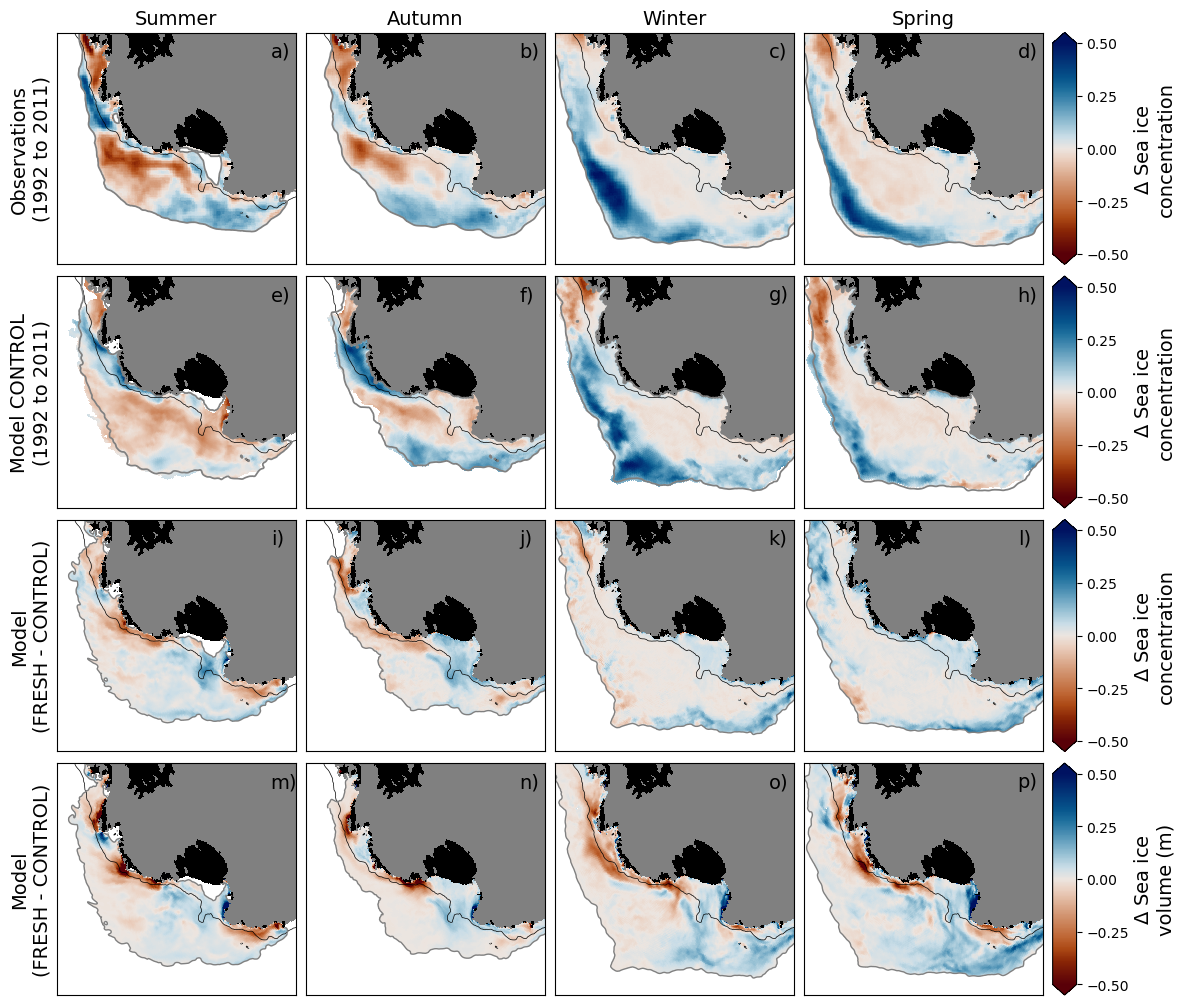

In [27]:
fig = figure(figsize=(12,11)) #(12,9)
gs  = gridspec.GridSpec(4, 1, height_ratios=[1,1,1,1], hspace=0.05)
gs0 = gridspec.GridSpecFromSubplotSpec(1, 5, width_ratios=[1,1,1,1,0.1], \
        subplot_spec=gs[0], wspace=0.05)
gs1 = gridspec.GridSpecFromSubplotSpec(1, 5, width_ratios=[1,1,1,1,0.1], \
        subplot_spec=gs[1], wspace=0.05)
gs2 = gridspec.GridSpecFromSubplotSpec(1, 5, width_ratios=[1,1,1,1,0.1], \
        subplot_spec=gs[2], wspace=0.05)
gs3 = gridspec.GridSpecFromSubplotSpec(1, 5, width_ratios=[1,1,1,1,0.1], \
        subplot_spec=gs[3], wspace=0.05)

for ii in range(len(season)):

    # Observations, delta SIC
    ax = fig.add_subplot(gs0[0,ii])#, aspect='equal')
    ax.text(0.895, 0.895, panel_name[ii], fontsize=ft_size, transform=ax.transAxes)
    title(season[ii], fontsize=ft_size)
    sc = pcolormesh(x_sic, y_sic, delta_SIC_NSIDC[ii,:,:], cmap=Vik_19_r.mpl_colormap, \
            vmin=-0.5, vmax=0.5, shading='nearest')
    contourf(x_reg, y_reg, land_circle_metroms, colors='0.5')
    contourf(x_roms, y_roms, lat_r, colors='0.5')
    contourf(x_roms, y_roms, zice*1, colors='k')
    if ii == 0:
        ylabel('Observations\n(1992 to 2011)', fontsize=ft_size)#, loc='left') #(1979 to 2015)'
    contour(x_roms, y_roms, h, levels=[1000], colors='k', linewidths=0.5)
    contour(x_sic, y_sic, sic_seasonal[ii,:,:], levels=[aice_extmin], linewidths=1.25, colors='0.5')
    setp(ax.get_xticklabels(), visible=False)
    setp(ax.get_yticklabels(), visible=False)
    ax.tick_params(axis='both', which='both', length=0)
    xlim(-25, 15)
    ylim(-30, 7)

    # Model, CNTR delta SIC
    ax = fig.add_subplot(gs1[0,ii])
    ax.text(0.895, 0.895, panel_name[ii+4], fontsize=ft_size, transform=ax.transAxes)
    sc = pcolormesh(x_cice, y_cice, trend_seasonal[ii,:,:]*20, cmap=Vik_19_r.mpl_colormap, vmin=-0.5, vmax=0.5)
    #sc = pcolormesh(x_cice, y_cice, aice_seasonal[ii,:,:], cmap=Vik_19_r.mpl_colormap, vmin=-0.5, vmax=0.5)
    contourf(x_reg, y_reg, land_circle_metroms, colors='0.5')
    contourf(x_roms, y_roms, lat_r, colors='0.5')
    contourf(x_roms, y_roms, zice*1, colors='k')
    if ii == 0:
        ylabel('Model CONTROL\n(1992 to 2011)', fontsize=ft_size)#, loc='left') #(1979 to 2015)'
    contour(x_roms, y_roms, h, levels=[1000], colors='k', linewidths=0.5)
    contour(x_cice, y_cice, aice_seasonal[ii,:,:], levels=[aice_extmin], linewidths=1.25, colors='0.5')
    setp(ax.get_xticklabels(), visible=False)
    setp(ax.get_yticklabels(), visible=False)
    ax.tick_params(axis='both', which='both', length=0)
    xlim(-25, 15)
    ylim(-30, 7)
        
        
    # Model, delta SIC
    ax = fig.add_subplot(gs2[0,ii])#, aspect='equal')
    ax.text(0.895, 0.895, panel_name[ii+8], fontsize=ft_size, transform=ax.transAxes)
    contourf(x_reg, y_reg, land_circle_metroms, colors='0.5')
    contourf(x_roms, y_roms, lat_r*0, colors='0.5')
    contourf(x_roms, y_roms, zice*1, colors='k')
    contour(x_roms, y_roms, h, levels=[1000], colors='k', linewidths=0.5)
    contour(x, y, aice_cntr[ii,:,:], levels=[aice_extmin], colors='0.5', linewidths=1)
    sc = pcolormesh(x, y, diff_aice_pert_4[ii,:,:], cmap=Vik_19_r.mpl_colormap, vmin=-0.5, vmax=0.5, shading='nearest')

    if ii == 0:
        ylabel('Model\n(FRESH - CONTROL)', fontsize=ft_size)#, loc='left')
    setp(ax.get_xticklabels(), visible=False)
    setp(ax.get_yticklabels(), visible=False)
    ax.tick_params(axis='both', which='both', length=0)
    xlim(-25, 15)
    ylim(-30, 7)

    # Model, delta SIV, effective
    ax = fig.add_subplot(gs3[0,ii])#, aspect='equal')
    ax.text(0.895, 0.895, panel_name[ii+12], fontsize=ft_size, transform=ax.transAxes)
    contourf(x_reg, y_reg, land_circle_metroms, colors='0.5')
    contourf(x_roms, y_roms, lat_r*0, colors='0.5')
    contourf(x_roms, y_roms, zice*1, colors='k')
    v_val = 0.5 # 1.25
    SC = pcolormesh(x, y, diff_siv_pert_4[ii,:,:], cmap=Vik_19_r.mpl_colormap, vmin=-v_val, vmax=v_val, shading='nearest')
    contour(x_roms, y_roms, h, levels=[1000], colors='k', linewidths=0.5)
    contour(x, y, aice_cntr[ii,:,:], levels=[aice_extmin], colors='0.5', linewidths=1)
    if ii == 0:
        ylabel('Model\n(FRESH - CONTROL)', fontsize=ft_size)#, loc='left')
    setp(ax.get_xticklabels(), visible=False)
    setp(ax.get_yticklabels(), visible=False)
    ax.tick_params(axis='both', which='both', length=0)
    xlim(-25, 15)
    ylim(-30, 7)


# Add colorbars
cbar_ax1 = fig.add_subplot(gs0[:,-1])
cbar_ax2 = fig.add_subplot(gs1[:,-1])
cbar_ax3 = fig.add_subplot(gs2[:,-1])
cbar_ax4 = fig.add_subplot(gs3[:,-1])
cbar = colorbar(sc, cax=cbar_ax1, ticks=np.arange(-0.5, 0.55, 0.25), extend='both')
cbar.set_label('$\Delta$ Sea ice\nconcentration', fontsize=ft_size)
cbar = colorbar(sc, cax=cbar_ax2, ticks=np.arange(-0.5, 0.55, 0.25), extend='both')
cbar.set_label('$\Delta$ Sea ice\nconcentration', fontsize=ft_size)
cbar = colorbar(sc, cax=cbar_ax3, ticks=np.arange(-0.5, 0.55, 0.25), extend='both')
# 1.1 Volume
#cbar.set_label('$\Delta$ Sea ice volume (km$^{3}$)', fontsize=12)
# 1.2 Effective volume
cbar.set_label('$\Delta$ Sea ice\nconcentration', fontsize=ft_size)
cbar = colorbar(SC, cax=cbar_ax4, ticks=np.arange(-0.5, 0.55, 0.25), extend='both')
cbar.set_label('$\Delta$ Sea ice\nvolume (m)', fontsize=ft_size)

subplots_adjust(right=0.9, left=0.05, bottom=0.075, top=0.95)

# Finished
plot_flag = 1
if plot_flag == 1:
    savefig(fig_path + 'Figure2_4SSFLUX.png', dpi=my_dpi)


/jobfs/89163620.gadi-pbs/ipykernel_3230449/1745332926.py:20: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  sc = pcolormesh(x, y, diff_aice_pert_4[ii,:,:], cmap=Vik_19_r.mpl_colormap, vmin=-0.5, vmax=0.5, shading='nearest')
/jobfs/89163620.gadi-pbs/ipykernel_3230449/1745332926.py:37: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  SC = pcolormesh(x, y, diff_siv_pert_4[ii,:,:], cmap=Vik_19_r.mpl_colormap, vmin=-v_val, vmax=v_val, shading='nearest')


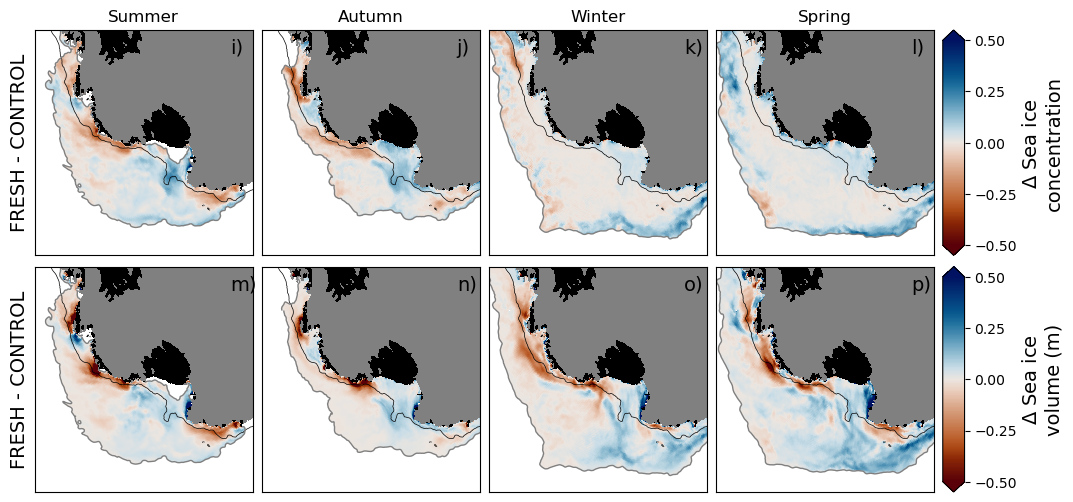

In [44]:
fig = figure(figsize=(12,6)) #(12,9)

gs  = gridspec.GridSpec(2, 1, height_ratios=[1,1], hspace=0.05)
gs0 = gridspec.GridSpecFromSubplotSpec(1, 5, width_ratios=[1,1,1,1,0.1], \
        subplot_spec=gs[0], wspace=0.05)
gs1 = gridspec.GridSpecFromSubplotSpec(1, 5, width_ratios=[1,1,1,1,0.1], \
        subplot_spec=gs[1], wspace=0.05)

for ii in range(len(season)):
      
    # Model, delta SIC
    ax = fig.add_subplot(gs0[0,ii])#, aspect='equal')
    ax.text(0.895, 0.895, panel_name[ii+8], fontsize=ft_size, transform=ax.transAxes)
    title(season[ii])
    contourf(x_reg, y_reg, land_circle_metroms, colors='0.5')
    contourf(x_roms, y_roms, lat_r*0, colors='0.5')
    contourf(x_roms, y_roms, zice*1, colors='k')
    contour(x_roms, y_roms, h, levels=[1000], colors='k', linewidths=0.5)
    contour(x, y, aice_cntr[ii,:,:], levels=[aice_extmin], colors='0.5', linewidths=1)
    sc = pcolormesh(x, y, diff_aice_pert_4[ii,:,:], cmap=Vik_19_r.mpl_colormap, vmin=-0.5, vmax=0.5, shading='nearest')

    if ii == 0:
        ylabel('FRESH - CONTROL', fontsize=ft_size)#, loc='left')
    setp(ax.get_xticklabels(), visible=False)
    setp(ax.get_yticklabels(), visible=False)
    ax.tick_params(axis='both', which='both', length=0)
    xlim(-25, 15)
    ylim(-30, 7)

    # Model, delta SIV, effective
    ax = fig.add_subplot(gs1[0,ii])#, aspect='equal')
    ax.text(0.895, 0.895, panel_name[ii+12], fontsize=ft_size, transform=ax.transAxes)
    contourf(x_reg, y_reg, land_circle_metroms, colors='0.5')
    contourf(x_roms, y_roms, lat_r*0, colors='0.5')
    contourf(x_roms, y_roms, zice*1, colors='k')
    v_val = 0.5 # 1.25
    SC = pcolormesh(x, y, diff_siv_pert_4[ii,:,:], cmap=Vik_19_r.mpl_colormap, vmin=-v_val, vmax=v_val, shading='nearest')
    contour(x_roms, y_roms, h, levels=[1000], colors='k', linewidths=0.5)
    contour(x, y, aice_cntr[ii,:,:], levels=[aice_extmin], colors='0.5', linewidths=1)
    if ii == 0:
        ylabel('FRESH - CONTROL', fontsize=ft_size)#, loc='left')
    setp(ax.get_xticklabels(), visible=False)
    setp(ax.get_yticklabels(), visible=False)
    ax.tick_params(axis='both', which='both', length=0)
    xlim(-25, 15)
    ylim(-30, 7)


# Add colorbars
cbar_ax0 = fig.add_subplot(gs0[:,-1])
cbar = colorbar(sc, cax=cbar_ax0, ticks=np.arange(-0.5, 0.55, 0.25), extend='both')
cbar.set_label('$\Delta$ Sea ice\nconcentration', fontsize=ft_size)
cbar_ax1 = fig.add_subplot(gs1[:,-1])
cbar = colorbar(SC, cax=cbar_ax1, ticks=np.arange(-0.5, 0.55, 0.25), extend='both')
cbar.set_label('$\Delta$ Sea ice\nvolume (m)', fontsize=ft_size)

# subplots_adjust(right=0.9, left=0.05, bottom=0.075, top=0.95)

# Finished
plot_flag = 1
if plot_flag == 1:
    savefig(fig_path + 'FigureS2_4SSFLUX.png', dpi=my_dpi)


### Figure S1

Evolution of sea ice anomaly in the perturbation compared with the control simulation.

Maybe global plot?

In [34]:
test = xr.open_dataset(path + 'POST_PROCESS/aice_hi_CONTROL_2002_2011_full_circumpolar.nc')

In [36]:
test.time

<xarray.DataArray 'time' (time: 716)>
array(['2002-02-12T00:00:00.000000000', '2002-02-17T00:00:00.000000000',
       '2002-02-22T00:00:00.000000000', ..., '2011-11-17T00:00:00.000000000',
       '2011-11-22T00:00:00.000000000', '2011-11-27T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2002-02-12 2002-02-17 ... 2011-11-27
Attributes:
    long_name:  model time
    bounds:     time_bounds

Import sea ice area and thickness

In [37]:
# Years 1
aice_hi_cntr_yr1   = xr.open_dataset(path + 'POST_PROCESS/aice_hi_CONTROL_2002_2011_full_circumpolar.nc').sel(time=slice('2002-12-01','2003-11-30')).groupby('time.season').mean('time').sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
aice_hi_pert_2_yr1 = xr.open_dataset(path + 'POST_PROCESS/aice_hi_2SSFLUX_2002_2011_full_circumpolar.nc').sel(time=slice('2002-12-01','2003-11-30')).groupby('time.season').mean('time').sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
aice_hi_pert_4_yr1 = xr.open_dataset(path + 'POST_PROCESS/aice_hi_4SSFLUX_2002_2011_full_circumpolar.nc').sel(time=slice('2002-12-01','2003-11-30')).groupby('time.season').mean('time').sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))


In [63]:
# Years 2
aice_hi_cntr_yr2   = xr.open_dataset(path + 'POST_PROCESS/aice_hi_CONTROL_2002_2011_full_circumpolar.nc').sel(time=slice('2003-12-01','2004-11-30')).groupby('time.season').mean('time').sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
aice_hi_pert_2_yr2 = xr.open_dataset(path + 'POST_PROCESS/aice_hi_2SSFLUX_2002_2011_full_circumpolar.nc').sel(time=slice('2003-12-01','2004-11-30')).groupby('time.season').mean('time').sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
aice_hi_pert_4_yr2 = xr.open_dataset(path + 'POST_PROCESS/aice_hi_4SSFLUX_2002_2011_full_circumpolar.nc').sel(time=slice('2003-12-01','2004-11-30')).groupby('time.season').mean('time').sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))


In [64]:
# Years 3
aice_hi_cntr_yr3   = xr.open_dataset(path + 'POST_PROCESS/aice_hi_CONTROL_2002_2011_full_circumpolar.nc').sel(time=slice('2004-12-01','2005-11-30')).groupby('time.season').mean('time').sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
aice_hi_pert_2_yr3 = xr.open_dataset(path + 'POST_PROCESS/aice_hi_2SSFLUX_2002_2011_full_circumpolar.nc').sel(time=slice('2004-12-01','2005-11-30')).groupby('time.season').mean('time').sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
aice_hi_pert_4_yr3 = xr.open_dataset(path + 'POST_PROCESS/aice_hi_4SSFLUX_2002_2011_full_circumpolar.nc').sel(time=slice('2004-12-01','2005-11-30')).groupby('time.season').mean('time').sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))


Extract area and thickness

In [65]:
# Extract aice, hi

# Years 1
aice_cntr_yr1   = aice_hi_cntr_yr1.aice[:,:-15,:-1]
aice_pert_2_yr1 = aice_hi_pert_2_yr1.aice[:,:-15,:-1]
aice_pert_4_yr1 = aice_hi_pert_4_yr1.aice[:,:-15,:-1]

hi_cntr_yr1   = aice_hi_cntr_yr1.hi[:,:-15,:-1]
hi_pert_2_yr1 = aice_hi_pert_2_yr1.hi[:,:-15,:-1]
hi_pert_4_yr1 = aice_hi_pert_4_yr1.hi[:,:-15,:-1]

# Years 2
aice_cntr_yr2   = aice_hi_cntr_yr2.aice[:,:-15,:-1]
aice_pert_2_yr2 = aice_hi_pert_2_yr2.aice[:,:-15,:-1]
aice_pert_4_yr2 = aice_hi_pert_4_yr2.aice[:,:-15,:-1]

hi_cntr_yr2   = aice_hi_cntr_yr2.hi[:,:-15,:-1]
hi_pert_2_yr2 = aice_hi_pert_2_yr2.hi[:,:-15,:-1]
hi_pert_4_yr2 = aice_hi_pert_4_yr2.hi[:,:-15,:-1]

# Years 3
aice_cntr_yr3   = aice_hi_cntr_yr3.aice[:,:-15,:-1]
aice_pert_2_yr3 = aice_hi_pert_2_yr3.aice[:,:-15,:-1]
aice_pert_4_yr3 = aice_hi_pert_4_yr3.aice[:,:-15,:-1]

hi_cntr_yr3   = aice_hi_cntr_yr3.hi[:,:-15,:-1]
hi_pert_2_yr3 = aice_hi_pert_2_yr3.hi[:,:-15,:-1]
hi_pert_4_yr3 = aice_hi_pert_4_yr3.hi[:,:-15,:-1]

Calculate effective sea cice volume (units: m) as sea ice concentration x sea ice thickness

In [66]:
# Years 1
siv_cntr_yr1   = aice_cntr_yr1 * hi_cntr_yr1
siv_pert_2_yr1 = aice_pert_2_yr1 * hi_pert_2_yr1
siv_pert_4_yr1 = aice_pert_4_yr1 * hi_pert_4_yr1

# Years 2
siv_cntr_yr2   = aice_cntr_yr2 * hi_cntr_yr2
siv_pert_2_yr2 = aice_pert_2_yr2 * hi_pert_2_yr2
siv_pert_4_yr2 = aice_pert_4_yr2 * hi_pert_4_yr2

# Years 3
siv_cntr_yr3   = aice_cntr_yr3 * hi_cntr_yr3
siv_pert_2_yr3 = aice_pert_2_yr3 * hi_pert_2_yr3
siv_pert_4_yr3 = aice_pert_4_yr3 * hi_pert_4_yr3

Calculate anomalies

In [67]:
# Years 1
diff_aice_pert_2_yr1 = aice_pert_2_yr1 - aice_cntr_yr1
diff_aice_pert_2_yr1 = diff_aice_pert_2_yr1.where(aice_cntr > aice_extmin, np.nan)
diff_siv_pert_2_yr1  = siv_pert_2_yr1 - siv_cntr_yr1
diff_siv_pert_2_yr1  = diff_siv_pert_2_yr1.where(aice_cntr > aice_extmin, np.nan)

# Years 2
diff_aice_pert_2_yr2 = aice_pert_2_yr2 - aice_cntr_yr2
diff_aice_pert_2_yr2 = diff_aice_pert_2_yr2.where(aice_cntr > aice_extmin, np.nan)
diff_siv_pert_2_yr2  = siv_pert_2_yr2 - siv_cntr_yr2
diff_siv_pert_2_yr2  = diff_siv_pert_2_yr2.where(aice_cntr > aice_extmin, np.nan)

# Years 3
diff_aice_pert_2_yr3 = aice_pert_2_yr3 - aice_cntr_yr3
diff_aice_pert_2_yr3 = diff_aice_pert_2_yr3.where(aice_cntr > aice_extmin, np.nan)
diff_siv_pert_2_yr3  = siv_pert_2_yr3 - siv_cntr_yr3
diff_siv_pert_2_yr3  = diff_siv_pert_2_yr3.where(aice_cntr > aice_extmin, np.nan)

Plotting

/jobfs/89163620.gadi-pbs/ipykernel_3230449/183325292.py:27: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  sc = pcolormesh(x, y, diff_aice_pert_2_yr1[0,:,:], cmap=Vik_19_r.mpl_colormap, vmin=-0.25, vmax=0.25, shading='nearest')
/jobfs/89163620.gadi-pbs/ipykernel_3230449/183325292.py:57: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  SC = pcolormesh(x, y, diff_siv_pert_2_yr1[0,:,:], cmap=Vik_19_r.mpl_colormap, vmin=-0.25, vmax=0.25, shading='nearest')
/jobfs/89163620.gadi-pbs/ipykernel_3230449/183325292.py:30: UserWarning: The input coordinates to pcolormesh are interpreted as cell ce

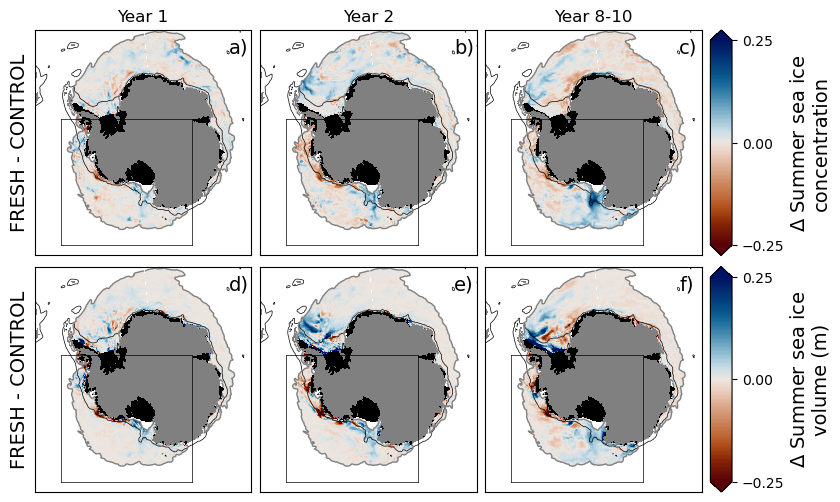

In [84]:
fig = figure(figsize=(9,6)) #(12,9)

gs  = gridspec.GridSpec(2, 1, height_ratios=[1,1], hspace=0.05)
gs0 = gridspec.GridSpecFromSubplotSpec(1, 4, width_ratios=[1,1,1,0.1], \
        subplot_spec=gs[0], wspace=0.05)
gs1 = gridspec.GridSpecFromSubplotSpec(1, 4, width_ratios=[1,1,1,0.1], \
        subplot_spec=gs[1], wspace=0.05)

for ii in range(3):
      
    # Model, delta SIC
    ax = fig.add_subplot(gs0[0,ii])#, aspect='equal')
    ax.text(0.895, 0.895, panel_name[ii], fontsize=ft_size, transform=ax.transAxes)
    if ii < 2:
        title('Year %i'%(ii+1))
    if ii == 2:
        title('Year 8-10')
    # title(season[ii])
    contourf(x_reg, y_reg, land_circle_metroms, colors='0.5')
    contourf(x_roms, y_roms, lat_r*0, colors='0.5')
    contourf(x_roms, y_roms, zice*1, colors='k')
    contour(x_roms, y_roms, h, levels=[1000], colors='k', linewidths=0.5)
    contour(x, y, aice_cntr[0,:,:], levels=[aice_extmin], colors='0.5', linewidths=1)
    # contour(x, y, aice_pert_2[ii,:,:], levels=[aice_extmin], colors='C0', linewidths=1)
    
    if ii == 0:
        sc = pcolormesh(x, y, diff_aice_pert_2_yr1[0,:,:], cmap=Vik_19_r.mpl_colormap, vmin=-0.25, vmax=0.25, shading='nearest')
        ylabel('FRESH - CONTROL', fontsize=ft_size)
    if ii == 1:
        sc = pcolormesh(x, y, diff_aice_pert_2_yr2[0,:,:], cmap=Vik_19_r.mpl_colormap, vmin=-0.25, vmax=0.25, shading='nearest')
    # if ii == 2:
    #     sc = pcolormesh(x, y, diff_aice_pert_2_yr3[0,:,:], cmap=Vik_19_r.mpl_colormap, vmin=-0.25, vmax=0.25, shading='nearest')
    if ii == 2:
        sc = pcolormesh(x, y, diff_aice_pert_2[0,:,:], cmap=Vik_19_r.mpl_colormap, vmin=-0.25, vmax=0.25, shading='nearest')
        
    setp(ax.get_xticklabels(), visible=False)
    setp(ax.get_yticklabels(), visible=False)
    ax.tick_params(axis='both', which='both', length=0)
    xlim(-33, 33)
    ylim(-33, 33)
    plot([-25, 15],[-30,-30], color='k', linewidth=0.5)
    plot([-25, 15],[7,7], color='k', linewidth=0.5)
    plot([-25, -25],[-30,7], color='k', linewidth=0.5)
    plot([15, 15],[-30,7], color='k', linewidth=0.5)

    # Model, delta SIV, effective
    ax = fig.add_subplot(gs1[0,ii])#, aspect='equal')
    ax.text(0.895, 0.895, panel_name[ii+3], fontsize=ft_size, transform=ax.transAxes)
    contourf(x_reg, y_reg, land_circle_metroms, colors='0.5')
    contourf(x_roms, y_roms, lat_r*0, colors='0.5')
    contourf(x_roms, y_roms, zice*1, colors='k')
    v_val = 0.5 # 1.25
    contour(x_roms, y_roms, h, levels=[1000], colors='k', linewidths=0.5)
    contour(x, y, aice_cntr[0,:,:], levels=[aice_extmin], colors='0.5', linewidths=1)
    
    if ii == 0:
        SC = pcolormesh(x, y, diff_siv_pert_2_yr1[0,:,:], cmap=Vik_19_r.mpl_colormap, vmin=-0.25, vmax=0.25, shading='nearest')
        ylabel('FRESH - CONTROL', fontsize=ft_size)
    if ii == 1:
        SC = pcolormesh(x, y, diff_siv_pert_2_yr2[0,:,:], cmap=Vik_19_r.mpl_colormap, vmin=-0.25, vmax=0.25, shading='nearest')
    # if ii == 2:
    #     SC = pcolormesh(x, y, diff_siv_pert_2_yr3[0,:,:], cmap=Vik_19_r.mpl_colormap, vmin=-0.25, vmax=0.25, shading='nearest')
    if ii == 2:
        SC = pcolormesh(x, y, diff_siv_pert_2[0,:,:], cmap=Vik_19_r.mpl_colormap, vmin=-0.25, vmax=0.25, shading='nearest')
        
    setp(ax.get_xticklabels(), visible=False)
    setp(ax.get_yticklabels(), visible=False)
    ax.tick_params(axis='both', which='both', length=0)
    xlim(-33, 33)
    ylim(-33, 33)
    plot([-25, 15],[-30,-30], color='k', linewidth=0.5)
    plot([-25, 15],[7,7], color='k', linewidth=0.5)
    plot([-25, -25],[-30,7], color='k', linewidth=0.5)
    plot([15, 15],[-30,7], color='k', linewidth=0.5)


# Add colorbars
cbar_ax0 = fig.add_subplot(gs0[:,-1])
cbar = colorbar(sc, cax=cbar_ax0, ticks=np.arange(-0.25, 0.3, 0.25), extend='both')
cbar.set_label('$\Delta$ Summer sea ice\nconcentration', fontsize=ft_size)
cbar_ax1 = fig.add_subplot(gs1[:,-1])
cbar = colorbar(SC, cax=cbar_ax1, ticks=np.arange(-0.25, 0.3, 0.25), extend='both')
cbar.set_label('$\Delta$ Summer sea ice\nvolume (m)', fontsize=ft_size)

# Finished
plot_flag = 1
if plot_flag == 1:
    savefig(fig_path + 'FigureS1_2SSFLUX.png', dpi=my_dpi, bbox_inches="tight")


### Quantification of signal

In [29]:
# Along longitudes (code for cross-section does not seem to work properly)
# lon_start = [170, 190, 170] 
# lon_end   = [170, 190, 190]
# lat_start = [-80, -80, -71]
# lat_end   = [-71, -75.5, -75.5]
lon_start = [190, 170] 
lon_end   = [190, 190]
lat_start = [-80, -71]
lat_end   = [-75.5, -75.5]

# Create array
lon_sec   = array((lon_start,lon_end))
lat_sec   = array((lat_start,lat_end))

# Convert to spherical coordinates
deg2rad = pi/180.0
x_sec    = -(lat_sec+90) * cos(lon_sec*deg2rad+pi/2)
y_sec    =  (lat_sec+90) * sin(lon_sec*deg2rad+pi/2)

/jobfs/99379321.gadi-pbs/ipykernel_988880/3425240479.py:18: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  sc = pcolormesh(x_sic, y_sic, delta_SIC_NSIDC[ii,:,:], cmap=Vik_19_r.mpl_colormap, \
/jobfs/99379321.gadi-pbs/ipykernel_988880/3425240479.py:41: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  sc = pcolormesh(x_cice, y_cice, trend_seasonal[ii,:,:]*20, cmap=Vik_19_r.mpl_colormap, vmin=-0.5, vmax=0.5)
/jobfs/99379321.gadi-pbs/ipykernel_988880/3425240479.py:66: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or d

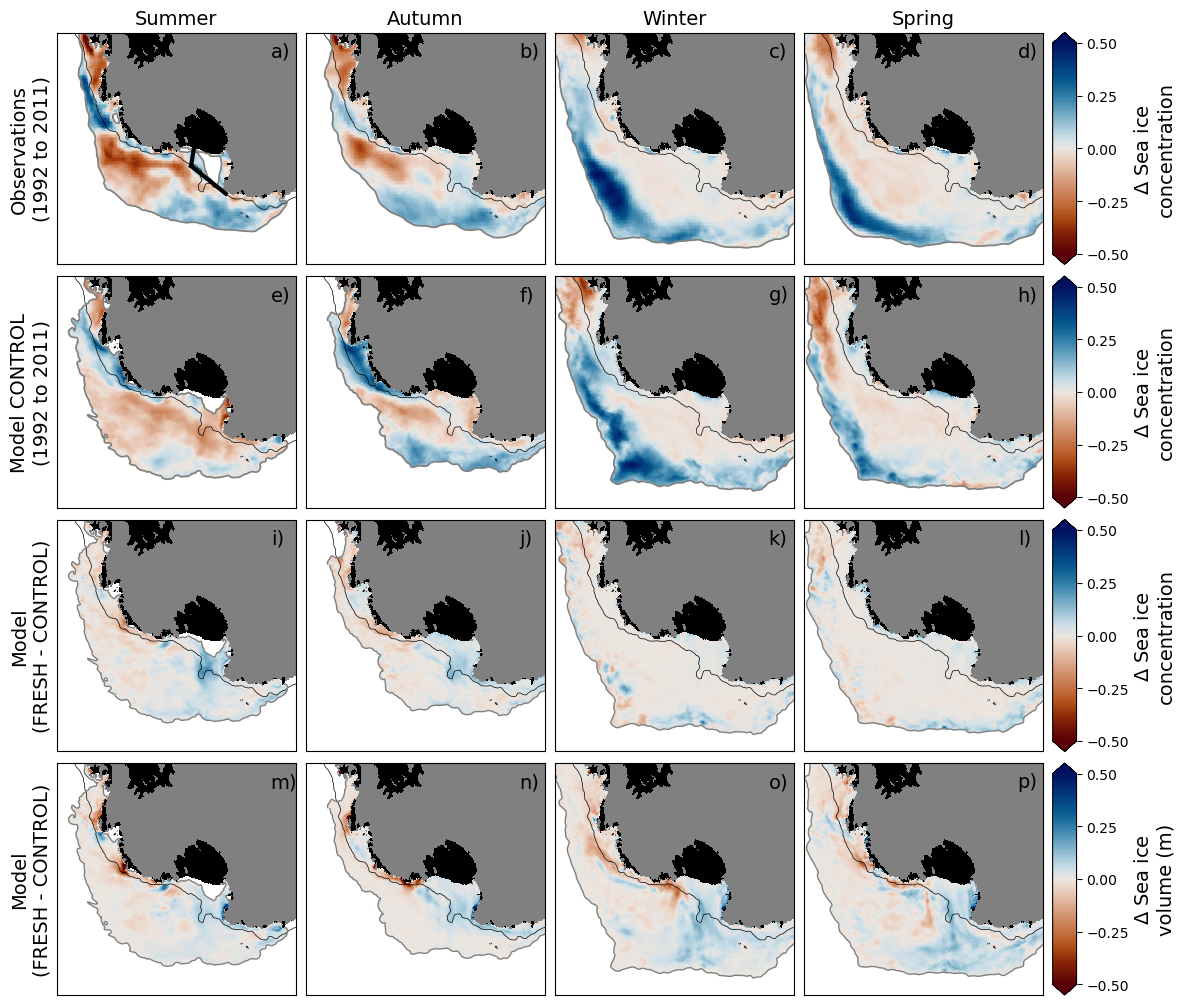

In [31]:
fig = figure(figsize=(12,11)) #(12,9)
gs  = gridspec.GridSpec(4, 1, height_ratios=[1,1,1,1], hspace=0.05)
gs0 = gridspec.GridSpecFromSubplotSpec(1, 5, width_ratios=[1,1,1,1,0.1], \
        subplot_spec=gs[0], wspace=0.05)
gs1 = gridspec.GridSpecFromSubplotSpec(1, 5, width_ratios=[1,1,1,1,0.1], \
        subplot_spec=gs[1], wspace=0.05)
gs2 = gridspec.GridSpecFromSubplotSpec(1, 5, width_ratios=[1,1,1,1,0.1], \
        subplot_spec=gs[2], wspace=0.05)
gs3 = gridspec.GridSpecFromSubplotSpec(1, 5, width_ratios=[1,1,1,1,0.1], \
        subplot_spec=gs[3], wspace=0.05)

for ii in range(len(season)):

    # Observations, delta SIC
    ax = fig.add_subplot(gs0[0,ii])#, aspect='equal')
    ax.text(0.895, 0.895, panel_name[ii], fontsize=ft_size, transform=ax.transAxes)
    title(season[ii], fontsize=ft_size)
    sc = pcolormesh(x_sic, y_sic, delta_SIC_NSIDC[ii,:,:], cmap=Vik_19_r.mpl_colormap, \
            vmin=-0.5, vmax=0.5, shading='nearest')
    contourf(x_reg, y_reg, land_circle_metroms, colors='0.5')
    contourf(x_roms, y_roms, lat_r, colors='0.5')
    contourf(x_roms, y_roms, zice*1, colors='k')
    if ii == 0:
        ylabel('Observations\n(1992 to 2011)', fontsize=ft_size)#, loc='left') #(1979 to 2015)'
    contour(x_roms, y_roms, h, levels=[1000], colors='k', linewidths=0.5)
    contour(x_sic, y_sic, sic_seasonal[ii,:,:], levels=[aice_extmin], linewidths=1.25, colors='0.5')
    setp(ax.get_xticklabels(), visible=False)
    setp(ax.get_yticklabels(), visible=False)
    ax.tick_params(axis='both', which='both', length=0)
    xlim(-25, 15)
    ylim(-30, 7)
    # Plot sections
    if ii == 0:
        for i in range(size(x_sec,1)):
            number = i+1
            plot(x_sec[:,i], y_sec[:,i], color='k', linewidth=3)

    # Model, CNTR delta SIC
    ax = fig.add_subplot(gs1[0,ii])
    ax.text(0.895, 0.895, panel_name[ii+4], fontsize=ft_size, transform=ax.transAxes)
    sc = pcolormesh(x_cice, y_cice, trend_seasonal[ii,:,:]*20, cmap=Vik_19_r.mpl_colormap, vmin=-0.5, vmax=0.5)
    #sc = pcolormesh(x_cice, y_cice, aice_seasonal[ii,:,:], cmap=Vik_19_r.mpl_colormap, vmin=-0.5, vmax=0.5)
    contourf(x_reg, y_reg, land_circle_metroms, colors='0.5')
    contourf(x_roms, y_roms, lat_r, colors='0.5')
    contourf(x_roms, y_roms, zice*1, colors='k')
    if ii == 0:
        ylabel('Model CONTROL\n(1992 to 2011)', fontsize=ft_size)#, loc='left') #(1979 to 2015)'
    contour(x_roms, y_roms, h, levels=[1000], colors='k', linewidths=0.5)
    # contour(x_cice, y_cice, aice_seasonal[ii,:,:], levels=[aice_extmin], linewidths=1.25, colors='0.5')
    contour(x, y, aice_cntr[ii,:,:], levels=[aice_extmin], linewidths=1.25, colors='0.5')
    setp(ax.get_xticklabels(), visible=False)
    setp(ax.get_yticklabels(), visible=False)
    ax.tick_params(axis='both', which='both', length=0)
    xlim(-25, 15)
    ylim(-30, 7)
        
        
    # Model, delta SIC
    ax = fig.add_subplot(gs2[0,ii])#, aspect='equal')
    ax.text(0.895, 0.895, panel_name[ii+8], fontsize=ft_size, transform=ax.transAxes)
    contourf(x_reg, y_reg, land_circle_metroms, colors='0.5')
    contourf(x_roms, y_roms, lat_r*0, colors='0.5')
    contourf(x_roms, y_roms, zice*1, colors='k')
    contour(x_roms, y_roms, h, levels=[1000], colors='k', linewidths=0.5)
    contour(x, y, aice_cntr[ii,:,:], levels=[aice_extmin], colors='0.5', linewidths=1)
    sc = pcolormesh(x, y, diff_aice_pert_2[ii,:,:], cmap=Vik_19_r.mpl_colormap, vmin=-0.5, vmax=0.5, shading='nearest')

    if ii == 0:
        ylabel('Model\n(FRESH - CONTROL)', fontsize=ft_size)#, loc='left')
    setp(ax.get_xticklabels(), visible=False)
    setp(ax.get_yticklabels(), visible=False)
    ax.tick_params(axis='both', which='both', length=0)
    xlim(-25, 15)
    ylim(-30, 7)

    # Model, delta SIV, effective
    ax = fig.add_subplot(gs3[0,ii])#, aspect='equal')
    ax.text(0.895, 0.895, panel_name[ii+12], fontsize=ft_size, transform=ax.transAxes)
    contourf(x_reg, y_reg, land_circle_metroms, colors='0.5')
    contourf(x_roms, y_roms, lat_r*0, colors='0.5')
    contourf(x_roms, y_roms, zice*1, colors='k')
    v_val = 0.5 # 1.25
    SC = pcolormesh(x, y, diff_siv_pert_2[ii,:,:], cmap=Vik_19_r.mpl_colormap, vmin=-v_val, vmax=v_val, shading='nearest')
    contour(x_roms, y_roms, h, levels=[1000], colors='k', linewidths=0.5)
    contour(x, y, aice_cntr[ii,:,:], levels=[aice_extmin], colors='0.5', linewidths=1)
    if ii == 0:
        ylabel('Model\n(FRESH - CONTROL)', fontsize=ft_size)#, loc='left')
    setp(ax.get_xticklabels(), visible=False)
    setp(ax.get_yticklabels(), visible=False)
    ax.tick_params(axis='both', which='both', length=0)
    xlim(-25, 15)
    ylim(-30, 7)


# Add colorbars
cbar_ax1 = fig.add_subplot(gs0[:,-1])
cbar_ax2 = fig.add_subplot(gs1[:,-1])
cbar_ax3 = fig.add_subplot(gs2[:,-1])
cbar_ax4 = fig.add_subplot(gs3[:,-1])
cbar = colorbar(sc, cax=cbar_ax1, ticks=np.arange(-0.5, 0.55, 0.25), extend='both')
cbar.set_label('$\Delta$ Sea ice\nconcentration', fontsize=ft_size)
cbar = colorbar(sc, cax=cbar_ax2, ticks=np.arange(-0.5, 0.55, 0.25), extend='both')
cbar.set_label('$\Delta$ Sea ice\nconcentration', fontsize=ft_size)
cbar = colorbar(sc, cax=cbar_ax3, ticks=np.arange(-0.5, 0.55, 0.25), extend='both')
# 1.1 Volume
#cbar.set_label('$\Delta$ Sea ice volume (km$^{3}$)', fontsize=12)
# 1.2 Effective volume
cbar.set_label('$\Delta$ Sea ice\nconcentration', fontsize=ft_size)
cbar = colorbar(SC, cax=cbar_ax4, ticks=np.arange(-0.5, 0.55, 0.25), extend='both')
cbar.set_label('$\Delta$ Sea ice\nvolume (m)', fontsize=ft_size)

subplots_adjust(right=0.9, left=0.05, bottom=0.075, top=0.95)

# Finished
plot_flag = 1
if plot_flag == 1:
    savefig(fig_path + 'Figure2_2SSFLUX.png', dpi=my_dpi)


In [33]:
lon_vec = np.arange(170, 191, 1)
lat_vec = np.linspace(-75.5, -71, len(lon_vec))[::-1]

CONTROL sea ice concentration trend

In [34]:
# Broad mask
mask_trend_1 = trend_seasonal.where( (trend_seasonal.TLON>160) & (trend_seasonal.TLON<190) )
mask_trend_2 = mask_trend_1.where((trend_seasonal.TLAT < -71.5) | (trend_seasonal.TLON>170))
# Refine mask
tmp = mask_trend_2
for ii in range(len(lon_vec)-1):
    tmp = tmp.where( ((tmp.TLON <=lon_vec[ii]) | (tmp.TLAT < lat_vec[ii])) & ((tmp.TLON >= 160) | (tmp.TLAT >= lat_vec.max())) )
mask_trend = tmp
mask_trend = mask_trend[:,:-13,:].where(isnan(h[:,:-1]) == False)
mask_trend = mask_trend.where(isnan(zice[:,:-1]) != 0)


FRESH-CONTROL sea ice concentration

In [35]:
# Broad mask
mask_dsic_1 = diff_aice_pert_2.where( (diff_aice_pert_2.TLON>160) & (diff_aice_pert_2.TLON<190) )
mask_dsic_2 = mask_dsic_1.where((diff_aice_pert_2.TLAT < -71.5) | (diff_aice_pert_2.TLON>170))
# Refine mask
tmp = mask_dsic_2
for ii in range(len(lon_vec)-1):
    tmp = tmp.where( ((tmp.TLON <=lon_vec[ii]) | (tmp.TLAT < lat_vec[ii])) & ((tmp.TLON >= 160) | (tmp.TLAT >= lat_vec.max())) )
mask_dsic = tmp


FRESH-CONTROL sea ice volume

In [36]:
# Broad mask
mask_dsiv_1 = diff_siv_pert_2.where( (diff_siv_pert_2.TLON>160) & (diff_siv_pert_2.TLON<190) )
mask_dsiv_2 = mask_dsiv_1.where((diff_siv_pert_2.TLAT < -71.5) | (diff_siv_pert_2.TLON>170))
# Refine mask
tmp = mask_dsiv_2
for ii in range(len(lon_vec)-1):
    tmp = tmp.where( ((tmp.TLON <=lon_vec[ii]) | (tmp.TLAT < lat_vec[ii])) & ((tmp.TLON >= 160) | (tmp.TLAT >= lat_vec.max())) )
mask_dsiv = tmp


NSIDC

In [37]:
lon_sic_360 = ones((332,316))
for i in range(332):
    for j in range(316):
        if lon_sic[i,j] < 0:
            lon_sic_360[i,j] = lon_sic[i,j] + 360
        else:
            lon_sic_360[i,j] = lon_sic[i,j]

In [38]:
delta_SIC_NSIDC_xa = xr.DataArray(delta_SIC_NSIDC)

In [39]:
# Broad mask
mask_NSIDC_1 = delta_SIC_NSIDC_xa.where( (lon_sic_360>160) & (lon_sic_360<190) )
mask_NSIDC_2 = mask_NSIDC_1.where((lat_sic < -71.5) | (lon_sic_360>170))
# Refine mask
tmp = mask_NSIDC_2
for ii in range(len(lon_vec)-1):
    tmp = tmp.where( ((lon_sic_360 <=lon_vec[ii]) | (lat_sic < lat_vec[ii])) & ((lon_sic_360 >= 160) | (lat_sic >= lat_vec.max())) )
mask_NSIDC = tmp.where(tmp**2 > 1e-7)


In [40]:
print('Sea ice concentration trend NSIDC')
for tt in range(4):
    print(season[tt], np.round(mask_NSIDC[tt,:,:].mean().values,3))

print('')
print('Sea ice concentration trend CONTROL')
for tt in range(4):
    print(season[tt], np.round(mask_trend[tt,:,:].mean().values * 20,3))

print('')
print('Sea ice concentration FRESH-CONTROL')
for tt in range(4):
    print(season[tt], np.round(mask_dsic[tt,:,:].mean().values,3))

print('')
print('Sea ice volume FRESH-CONTROL')
for tt in range(4):
    print(season[tt], np.round(mask_dsiv[tt,:,:].mean().values,3))

Sea ice concentration trend NSIDC
Summer 0.051
Autumn 0.031
Winter 0.015
Spring 0.019

Sea ice concentration trend CONTROL
Summer -0.097
Autumn -0.031
Winter 0.01
Spring 0.009

Sea ice concentration FRESH-CONTROL
Summer 0.084
Autumn 0.053
Winter 0.016
Spring 0.02

Sea ice volume FRESH-CONTROL
Summer 0.065
Autumn 0.058
Winter 0.067
Spring 0.072


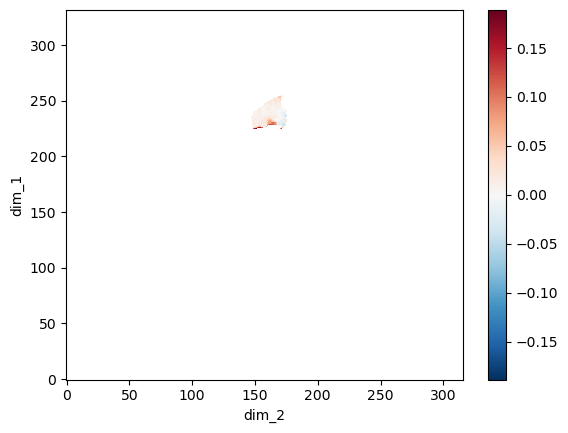

In [228]:
mask_NSIDC[2,:,:].plot()

In [184]:
# Broad mask
mask_NSIDC_1 = ma.masked_where( (lon_sic_360 < 160) | (lon_sic_360 > 190), delta_SIC_NSIDC[0,:,:])
mask_NSIDC_2 = ma.masked_where( (lon_sic_360 < 170) & (lat_sic > -71.5), mask_NSIDC_1)
# Refine mask
tmp = mask_NSIDC_2
for ii in range(len(lon_vec)-1):
    tmp = ma.masked_where( ((lon_sic_360 <=lon_vec[ii]) | (lat_sic < lat_vec[ii])) & ((lon_sic_360 >= 160) | (lat_sic >= lat_vec.max())), tmp )
mask_NSIDC = tmp


# test_ma = ma.masked_where((lon_sic>-170) & (lon_sic<160), test)
# test_ma_2 = ma.masked_where((lat_sic>-71.5) & (lon_sic<170) & (lon_sic > 0), test_ma) #& (lon_sic<170) # (lat_sic>-71.5)


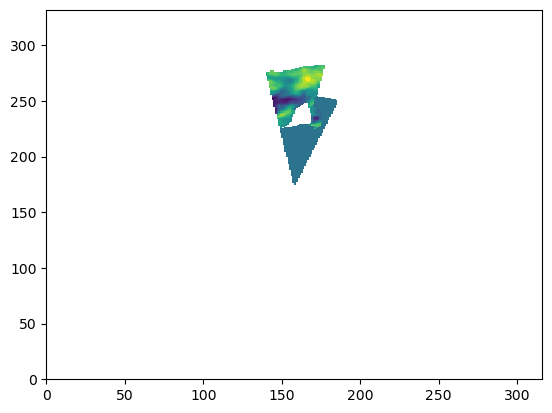

In [187]:
pcolor(mask_NSIDC_2)

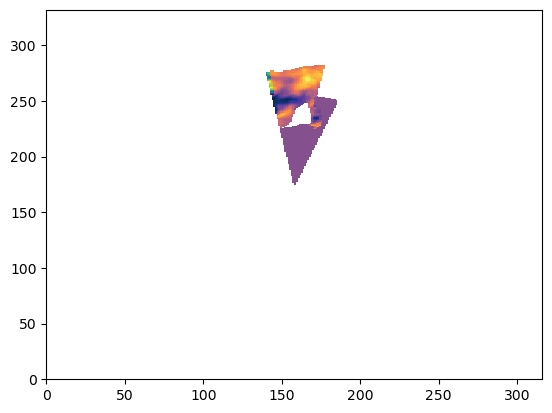

In [190]:
tmp = mask_NSIDC_2
# for ii in range(len(lon_vec)-1):
#     tmp = ma.masked_where( ((lon_sic_360 <=lon_vec[ii]) | (lat_sic < lat_vec[ii])) & ((lon_sic_360 >= 160) | (lat_sic >= lat_vec.max())), tmp )

tmp = ma.masked_where( () , tmp)

mask_NSIDC = tmp

pcolor(mask_NSIDC_2, cmap=cmo.thermal)
pcolor(mask_NSIDC)


/jobfs/99365016.gadi-pbs/ipykernel_1872224/3674766791.py:15: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  sc = pcolormesh(x_cice, y_cice, mask_trend[ii,:,:]*20, cmap=Vik_19_r.mpl_colormap, vmin=-0.5, vmax=0.5)


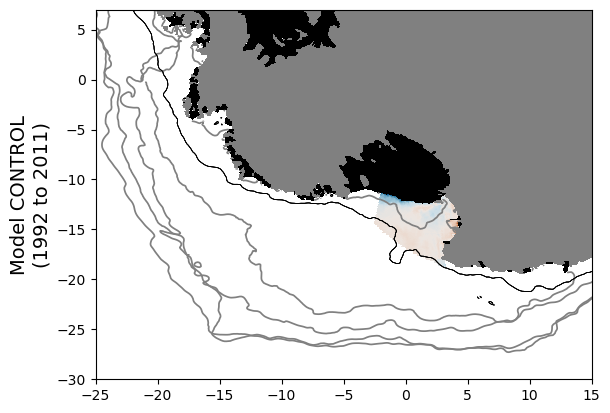

In [37]:
gs  = gridspec.GridSpec(4, 1, height_ratios=[1,1,1,1], hspace=0.05)
gs0 = gridspec.GridSpecFromSubplotSpec(1, 5, width_ratios=[1,1,1,1,0.1], \
        subplot_spec=gs[0], wspace=0.05)
gs1 = gridspec.GridSpecFromSubplotSpec(1, 5, width_ratios=[1,1,1,1,0.1], \
        subplot_spec=gs[1], wspace=0.05)
gs2 = gridspec.GridSpecFromSubplotSpec(1, 5, width_ratios=[1,1,1,1,0.1], \
        subplot_spec=gs[2], wspace=0.05)
gs3 = gridspec.GridSpecFromSubplotSpec(1, 5, width_ratios=[1,1,1,1,0.1], \
        subplot_spec=gs[3], wspace=0.05)

for ii in range(4):
    # Model, CNTR delta SIC
    ax = fig.add_subplot(gs1[0,ii])
    ax.text(0.895, 0.895, panel_name[ii+4], fontsize=ft_size, transform=ax.transAxes)
    sc = pcolormesh(x_cice, y_cice, mask_trend[ii,:,:]*20, cmap=Vik_19_r.mpl_colormap, vmin=-0.5, vmax=0.5)
    #sc = pcolormesh(x_cice, y_cice, aice_seasonal[ii,:,:], cmap=Vik_19_r.mpl_colormap, vmin=-0.5, vmax=0.5)
    contourf(x_reg, y_reg, land_circle_metroms, colors='0.5')
    contourf(x_roms, y_roms, lat_r, colors='0.5')
    contourf(x_roms, y_roms, zice*1, colors='k')
    if ii == 0:
        ylabel('Model CONTROL\n(1992 to 2011)', fontsize=ft_size)#, loc='left') #(1979 to 2015)'
    contour(x_roms, y_roms, h, levels=[1000], colors='k', linewidths=0.5)
    # contour(x_cice, y_cice, aice_seasonal[ii,:,:], levels=[aice_extmin], linewidths=1.25, colors='0.5')
    contour(x, y, aice_cntr[ii,:,:], levels=[aice_extmin], linewidths=1.25, colors='0.5')
    setp(ax.get_xticklabels(), visible=False)
    setp(ax.get_yticklabels(), visible=False)
    ax.tick_params(axis='both', which='both', length=0)
    xlim(-25, 15)
    ylim(-30, 7)

<xarray.DataArray 'aice' (time: 4, nj: 428, ni: 1440)>
array([[[1.52587891e-05, 1.52587891e-05, 1.52587891e-05, ...,
         1.52587891e-05, 1.52587891e-05, 1.52587891e-05],
        [1.52587891e-05, 1.52587891e-05, 1.52587891e-05, ...,
         1.52587891e-05, 1.52587891e-05, 1.52587891e-05],
        [1.52587891e-05, 1.52587891e-05, 1.52587891e-05, ...,
         1.52587891e-05, 1.52587891e-05, 1.52587891e-05],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[1.52587891e-05, 1.52587891e-05, 1.52587891e-05, ...,
         1.52587891e-05, 1.52587891e-05, 1.52587891e-05],
        [1.52587891e-05, 1.52587891e-05, 1.52587891e-05, ...,
         1.52587891e-05, 1.52587891e-05, 1.52587891e-05],
        [1.52587891e-05, 1.52587891e-05, 1.52587891e-05, ...,
         1.52587891e-05, 1.52587891e-05, 1.52587891e-05],
...
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[1.52587891e-05, 1.52587891e-05, 1.52587891e-05, ...,
         1.52587891e-05, 1.52587891e-05, 1.52587891e-05],
        [1.52587891e-05, 1.52587891e-05, 1.52587891e-05, ...,
         1.52587891e-05, 1.52587891e-05, 1.52587891e-05],
        [1.52587891e-05, 1.52587891e-05, 1.52587891e-05, ...,
         1.52587891e-05, 1.52587891e-05, 1.52587891e-05],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]]])
Coordinates:
  * time     (time) <U6 'Summer' 'Autumn' 'Winter' 'Spring'
    TLAT     (nj, ni) float32 -75.38 -75.36 -75.34 ... -30.43 -30.43 -30.43
    TLON     (nj, ni) float32 11.94 12.12 12.3 12.48 ... 359.1 359.4 359.6 359.9
Dimensions without coordinates: nj, ni

NSIDC

(332, 316)


(200.0, 300.0)

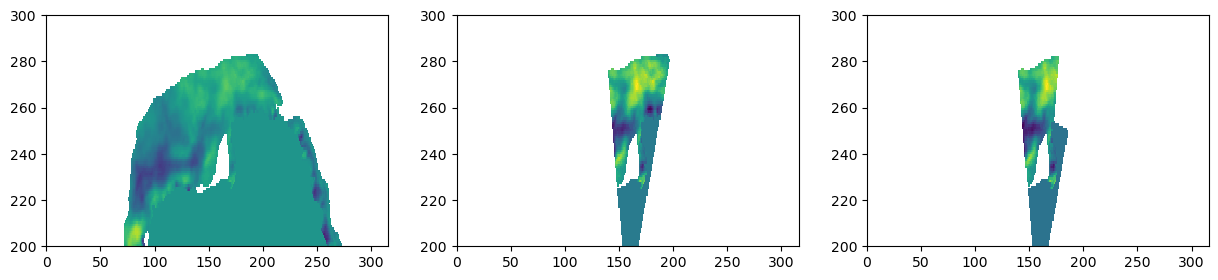

In [77]:
test = delta_SIC_NSIDC[0,...]
print(shape(test))
# var = var.where((data.TLAT <= latmax) & (data.TLON >= lonmin) & (data.TLON <= lonmax), drop=True)
# h    = ma.masked_where(ma.getmask(temp), h)
# ma.masked_where(condition, a, copy=True)
# test_ma = ma.masked_where(lon_sic<160, test)
test_ma = ma.masked_where((lon_sic>-170) & (lon_sic<160), test)
test_ma_2 = ma.masked_where((lat_sic>-71.5) & (lon_sic<170) & (lon_sic > 0), test_ma) #& (lon_sic<170) # (lat_sic>-71.5)
fig = figure(figsize=(15,3))

subplot(131)
pcolor(test)
ylim(200, 300)

subplot(132)
pcolor(test_ma)
ylim(200, 300)

subplot(133)
pcolor(test_ma_2)
ylim(200, 300)

(240.0, 280.0)

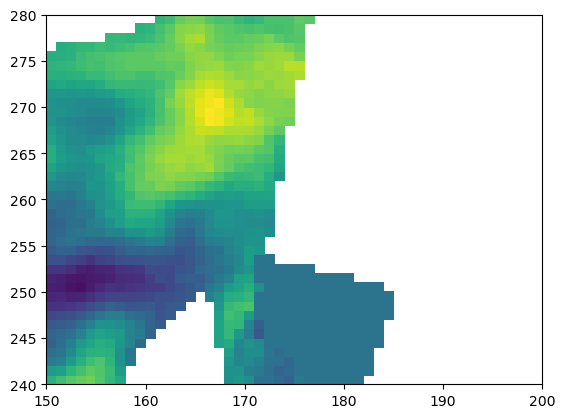

In [79]:
pcolor(test_ma_2)
xlim(150,200)
ylim(240, 280)

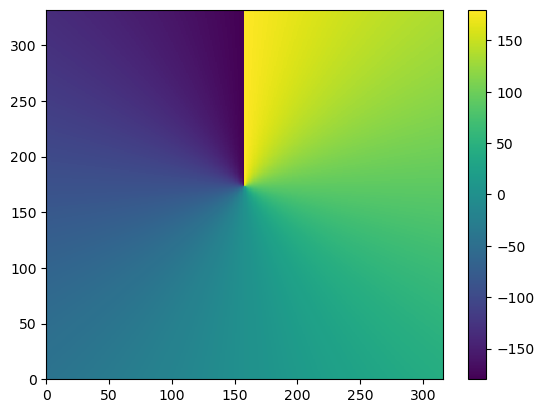

In [47]:
pcolor(lon_sic)
colorbar()

Model data

In [110]:
shape(h)

(415, 1441)

In [112]:
test_model_ma_2

<xarray.DataArray 'aice' (season: 4, nj: 413, ni: 1439)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
    TLON     (nj, ni) float32 11.94 12.12 12.3 12.48 ... 358.9 359.1 359.4 359.6
    TLAT     (nj, ni) float32 -75.38 -75.36 -75.34 ... -33.61 -33.61 -33.61
    ULON     (nj, ni) float32 12.03 12.21 12.39 12.57 ... 359.3 359.5 359.8
    ULAT     (nj, ni) float32 -75.37 -75.35 -75.33 ... -33.51 -33.51 -33.51
  * season   (season) object 'DJF' 'MAM' 'JJA' 'SON'
Dimensions without coordinates: nj, ni

In [136]:
print('')
print('Change in SIC, trend CONTROL:')
for tt in range(4):
    test_model_ma_1 = trend_seasonal.where( (trend_seasonal.TLON>160) & (trend_seasonal.TLON<190) )
    test_model_ma_2 = test_model_ma_1.where((trend_seasonal.TLAT < -71.5) | (trend_seasonal.TLON>170))
    test_model_ma_3 = test_model_ma_2.where(trend_seasonal.TLAT < -71.5)
    test_model_ma_h = test_model_ma_2[tt,:-15,:-1].where(h[1:-1,1:-1] < 1000)
    area_mean = nanmean(test_model_ma_h)
    print(season[tt], round(area_mean, 4))

print('')
print('Change in SIC, FRESH-CONTROL:')
for tt in range(4):
    test_model_ma_1 = diff_aice_pert_2.where( (diff_aice_pert_2.TLON>160) & (diff_aice_pert_2.TLON<190) )
    test_model_ma_2 = test_model_ma_1.where((diff_aice_pert_2.TLAT < -71.5) | (diff_aice_pert_2.TLON>170))
    test_model_ma_3 = test_model_ma_2.where(diff_aice_pert_2.TLAT < -71.5)
    test_model_ma_h = test_model_ma_2[tt,:,:].where(h[1:-1,1:-1] < 1000)
    area_mean = nanmean(test_model_ma_h)
    print(season[tt], round(area_mean, 4))

print('')
print('Change in SIV, FRESH-CONTROL:')
for tt in range(4):
    test_model_ma_1 = diff_siv_pert_2.where( (diff_siv_pert_2.TLON>160) & (diff_siv_pert_2.TLON<190) )
    test_model_ma_2 = test_model_ma_1.where((diff_siv_pert_2.TLAT < -71.5) | (diff_siv_pert_2.TLON>170))
    test_model_ma_h = test_model_ma_2[tt,:,:].where(h[1:-1,1:-1] < 1000)
    area_mean = nanmean(test_model_ma_h)
    print(season[tt], round(area_mean, 4))
    
# trend_seasonal


Change in SIC, trend CONTROL:
Summer -0.0011
Autumn -0.0005
Winter 0.0002
Spring 0.0002

Change in SIC, FRESH-CONTROL:
Summer 0.0924
Autumn 0.0574
Winter 0.0163
Spring 0.0201

Change in SIV, FRESH-CONTROL:
Summer 0.0675
Autumn 0.0604
Winter 0.0703
Spring 0.0747


/jobfs/99309042.gadi-pbs/ipykernel_2641231/3941681003.py:1: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcolormesh(x, y, diff_aice_pert_2[0,:,:])


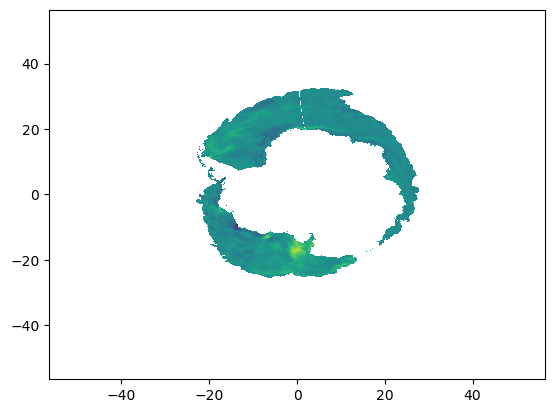

In [92]:
pcolormesh(x, y, diff_aice_pert_2[0,:,:])

/jobfs/99309042.gadi-pbs/ipykernel_2641231/2229988869.py:1: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcolormesh(x, y, test_model_ma[0,:,:])


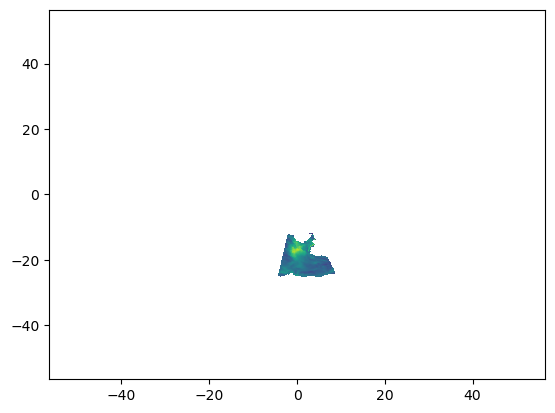

In [93]:
pcolormesh(x, y, test_model_ma[0,:,:])

/jobfs/99309042.gadi-pbs/ipykernel_2641231/1779978209.py:1: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcolormesh(x, y, test_model_ma_2[0,:,:])


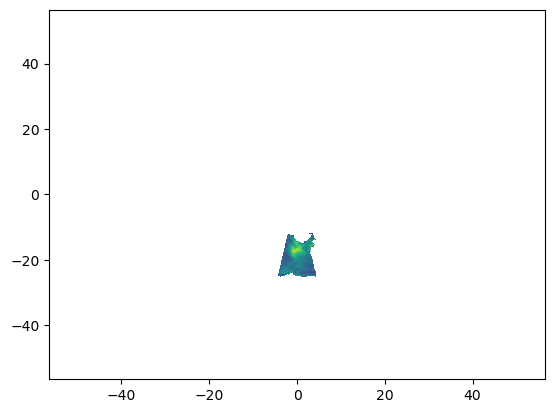

In [106]:
pcolormesh(x, y, test_model_ma_2[0,:,:])

/jobfs/99309042.gadi-pbs/ipykernel_2641231/1617977213.py:1: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcolormesh(x,y,test_model_ma_h)


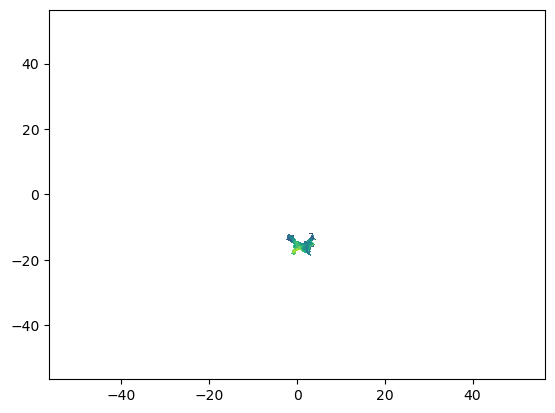

In [115]:
pcolormesh(x,y,test_model_ma_h)

/jobfs/99309042.gadi-pbs/ipykernel_2641231/3812881781.py:1: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcolormesh(x, y, test_model_ma_3[0,:,:])


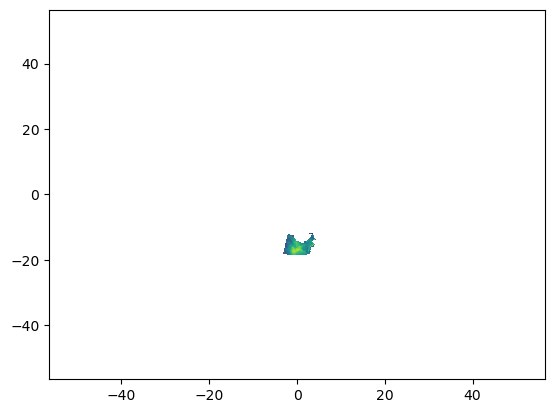

In [125]:
pcolormesh(x, y, test_model_ma_3[0,:,:])

In [128]:
trend_seasonal

<xarray.DataArray 'aice' (time: 4, nj: 428, ni: 1440)>
array([[[1.52587891e-05, 1.52587891e-05, 1.52587891e-05, ...,
         1.52587891e-05, 1.52587891e-05, 1.52587891e-05],
        [1.52587891e-05, 1.52587891e-05, 1.52587891e-05, ...,
         1.52587891e-05, 1.52587891e-05, 1.52587891e-05],
        [1.52587891e-05, 1.52587891e-05, 1.52587891e-05, ...,
         1.52587891e-05, 1.52587891e-05, 1.52587891e-05],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[1.52587891e-05, 1.52587891e-05, 1.52587891e-05, ...,
         1.52587891e-05, 1.52587891e-05, 1.52587891e-05],
        [1.52587891e-05, 1.52587891e-05, 1.52587891e-05, ...,
         1.52587891e-05, 1.52587891e-05, 1.52587891e-05],
        [1.52587891e-05, 1.52587891e-05, 1.52587891e-05, ...,
         1.52587891e-05, 1.52587891e-05, 1.52587891e-05],
...
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[1.52587891e-05, 1.52587891e-05, 1.52587891e-05, ...,
         1.52587891e-05, 1.52587891e-05, 1.52587891e-05],
        [1.52587891e-05, 1.52587891e-05, 1.52587891e-05, ...,
         1.52587891e-05, 1.52587891e-05, 1.52587891e-05],
        [1.52587891e-05, 1.52587891e-05, 1.52587891e-05, ...,
         1.52587891e-05, 1.52587891e-05, 1.52587891e-05],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]]])
Coordinates:
  * time     (time) <U6 'Summer' 'Autumn' 'Winter' 'Spring'
    TLAT     (nj, ni) float32 -75.38 -75.36 -75.34 ... -30.43 -30.43 -30.43
    TLON     (nj, ni) float32 11.94 12.12 12.3 12.48 ... 359.1 359.4 359.6 359.9
Dimensions without coordinates: nj, ni

In [138]:
shape(delta_SIC_NSIDC)

(4, 332, 316)

In [140]:
shape(h)

(415, 1441)

In [141]:
shape(lat_roms)

(415, 1441)

In [142]:
shape(lat_sic)

(332, 316)

In [176]:
lon_sic_360 = ones((332,316))
for i in range(332):
    for j in range(316):
        if lon_sic[i,j] < 0:
            lon_sic_360[i,j] = -lon_sic[i,j] + 180
        else:
            lon_sic_360[i,j] = lon_sic[i,j]

In [143]:
import scipy as sc

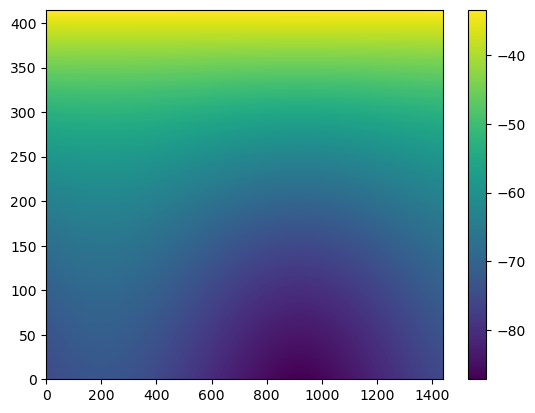

In [58]:
pcolor(lat_roms)
colorbar()

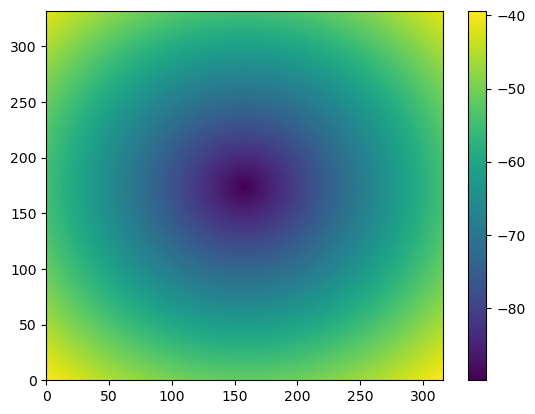

In [42]:
pcolor(lat_sic)
colorbar()

In [49]:
import cosima_cookbook as cc
session = cc.database.create_session()
experiment = '025deg_jra55_ryf9091_gadi'
bathymetry = cc.querying.getvar(experiment, 'ht', session, n=1)

In [30]:
import scipy as sc

In [35]:
from scipy.interpolate import SmoothBivariateSpline  # $scipy/interpolate/fitpack2.py

In [ ]:
test_NSIDC = sc.interpolate.griddata(lon_sic, delta_SIC_NSIDC[0,:,:], lon_roms, method='linear')

In [38]:
# test_h = sc.interpolate.griddata(lat_roms[:,::5], h[:,::5], lat_sic, method='linear')
# test_h = sc.interpolate.griddata(lat_roms, h, lat_sic, method='linear')

ValueError: x, y, z, and w should have a same length

In [ ]:
test_h = sc.interpolate.griddata(lat_roms[:,::5], h[:,::5], lat_sic, method='linear')